In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from utils import *


import cvxpy as cp
import gurobipy as gp
from gurobipy import GRB

## Create data

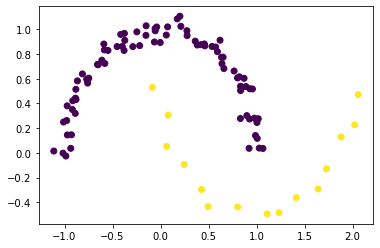

In [2]:
## number of samples
N = 100

np.random.seed(10)
x,y=make_moons(n_samples=(N-15,15),shuffle=False,noise=0.05)

plt.figure()
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [3]:
## optimization variables

k = 16 # number of centroids
r1 = .18 # radius constraint for SDP
r2 = .18 # radius constraint for 


d = pairwise_distances(x)**2

In [4]:
### variables and parameters
r = r1
D = cp.Parameter(shape=(N,N),symmetric=True,value=d)
M =[]
for a in range(k):
    M.append(cp.Variable(shape=(N,N),symmetric=True))
b = cp.Variable(shape=(N,k))

## solving SDP with constant cardinality to avoid linear fractional
n = [N//k for a in range(k)]

### constraints
cons_b = [cp.sum(b,axis=1) == (2-k)*np.ones(N)]

cons_M = [cp.diag(M[a])==1 for a in range(k)] + \
         [cp.vstack([cp.hstack([M[a],b[:,a][...,None]]),
         cp.hstack([b[:,a][...,None].T,np.ones((1,1))])]) >> 0 for a in range(k)]

cons_radius = [cp.multiply(
    D,M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T) <= 16*r**2 for a in range(k)]

cons_card = [cp.sum(b[:,a]) == 2*n[a]-N for a in range(k)] +\
                [cp.sum(M[a],axis=1) == (2*n[a]-N)*b[:,a] for a in range(k)]

## reform linearization constriants, can be avoided for N>=100
cons_reform_M = [M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T >= 0  for a in range(k)] + \
                [M[a] - np.ones((N,N)) + b[:,a] @ np.ones(N).T - np.ones(N) @ b[:,a].T <=0  for a in range(k)] + \
                [M[a] - np.ones((N,N)) - b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T <=0  for a in range(k)] + \
                [M[a] + np.ones((N,N)) - b[:,a] @ np.ones(N).T - np.ones(N) @ b[:,a].T >=0  for a in range(k)] 


cons = cons_b + cons_M + cons_radius

obj_f = 1/8*cp.sum(cp.multiply(D,1/n[a]*cp.sum([M[a] + np.ones((N,N)) + b[:,a] @ np.ones(N).T + np.ones(N) @ b[:,a].T \
                for a in range(k)])))

obj = cp.Minimize(obj_f)
problem = cp.Problem(obj,cons)
problem.solve(verbose=True,solver=cp.MOSEK)

NameError: name 'r' is not defined

In [5]:
with np.load('100_moons_b.npz') as data:
    b_value = data['b_value']

In [6]:
class empty(object):
    def __init__(self):
        self.value = None
b = empty()
b.value = b_value

In [7]:
model = gp.Model('cons_kmeans')
bf = b.value

p = []
for i in range(N):
    for a in range(k):
        p.append(model.addVar(vtype=GRB.BINARY,name="occupancy"))
p = np.stack(p).reshape(N,k)

r=r2
model.setObjective(sum([p[i,a]*bf[i,a] for i in range(N) for a in range(k)]),GRB.MAXIMIZE)
model.addConstrs(p[:,a] @ np.ones(N) <= N//5 for a in range(k))
model.addConstrs(p[i,:] @ np.ones(k) == 1 for i in range(N));
model.addConstrs(p[i,a]*d[i,j]*p[j,a] <= 4*r**2 for i in range(N) for j in range(N) for a in range(k));

model.optimize()

Academic license - for non-commercial use only - expires 2022-04-11
Using license file /home/imtiaz/gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 116 rows, 1600 columns and 3200 nonzeros
Model fingerprint: 0xbfc73b9a
Model has 160000 quadratic constraints
Variable types: 0 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [9e-06, 1e+01]
  Objective range  [9e-01, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
  QRHS range       [1e-01, 1e-01]
Presolve time: 1.85s
Presolved: 134900 rows, 68992 columns, 272768 nonzeros
Variable types: 0 continuous, 68992 integer (68992 binary)
Found heuristic solution: objective -87.5000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    9318    8.7500137e+01   5.891791e+01   0.000000e+00      5s

Roo

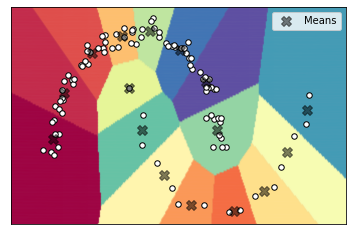

In [8]:
labels = np.argmax(np.stack([[n.x for n in each] for each in p]),axis=1)
labels = labelsort(x,labels)
centroids = np.stack([np.mean(x[labels==each],0)for each in np.unique(labels)])

ax = plot_partition_2D(x,centroids)
ax.set_xlim([-1.5,2.5])
ax.set_ylim([-.6,1.2])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [9]:
partition_radius(x,centroids)

array([0.14377745, 0.16415915, 0.1721312 , 0.06196598, 0.15455694,
       0.1901954 , 0.11899835, 0.13615796, 0.15034659, 0.        ,
       0.10896691, 0.16866777, 0.12658698, 0.1238394 , 0.16641176,
       0.16991628])

In [10]:
k_radius(x,centroids)

array([0.15897693, 0.17072713, 0.18518782, 0.06196598, 0.15455694,
       0.21194683, 0.11899835, 0.13615796, 0.15034659, 0.        ,
       0.12940607, 0.17709071, 0.12658698, 0.1238394 , 0.17735956,
       0.2078113 ])